In [ ]:
# Sourced from: https://www.python-engineer.com/courses/pytorchbeginner/13-feedforward-neural-network/

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn import preprocessing

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Hyper-parameters 
input_size = 784 # 28x28 for MNIST
input_size_mnist = 784 # 28x28 for MNIST
input_size_cifar_gray = 1024 # 1x32x32 for CIFAR-10 grayscale
input_size_cifar_rgb = 3072 # 3x32x32 for CIFAR-10 rgb
hidden_size = 2000 
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 0.004

# TODO adjust these as per the configuration in the paper.
# Especially how learning rate changes


In [ ]:
# TYPICAL PIPELINE

# 1) LOAD DATA
# 2) DESIGN MODEL
# 3) LOSS AND OPTIMIZER
# 4) TRAINING LOOP
#        - FORWARD PASS: computer prediction and calculate error
#        - BACKWARD PASS: calculate gradients
#        - UPDATE WEIGHTS
#        - SET ZERO GRAD IF USING AUTOGRAD

# 5) TEST MODEL WITH TEST DATA


In [ ]:
# 1) LOAD MNIST DATA

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [4]:
# 1) LOAD CIFAR-10 DATA

transform = transforms.Compose([transforms.ToTensor()])
transform_grayscale = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# CIFAR-10 dataset 
# train_dataset = torchvision.datasets.CIFAR10(root='./gray_data', 
#                                             train=True, 
#                                             transform=transform,  
#                                             download=True)

# test_dataset = torchvision.datasets.CIFAR10(root='./gray_data', 
#                                           train=False, 
#                                           transform=transform)

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=True, 
                                            transform=transform,  
                                            download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False, 
                                          transform=transform)

Files already downloaded and verified


(3, 32, 32)
(32, 32, 3)


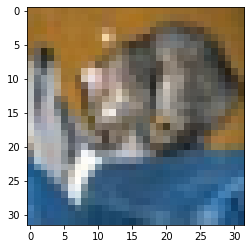

In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

def imshow(img):
    # Unnormalize line not needed because there is no normalization applied
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    npimg_transpose = np.transpose(npimg, (1, 2, 0))
    print(npimg_transpose.shape)
    plt.imshow(npimg_transpose)
    plt.show()


examples = iter(test_loader)
example_data, example_targets = examples.next()
image = example_data[0]
imshow(image)

#npimg = image.numpy()
#npimg = npimg.reshape(32, 32, 3) # DOES NOT WORK!
#npimg = np.transpose(npimg, (1, 2, 0)) # WORKS
# Using transpose instead of reshape actually help to display the image correctly
#print(npimg.shape)
#plt.imshow(npimg)



In [ ]:
# Test data shapes from loader

for i, (images, labels) in enumerate(train_loader):
    print(i)
    print(images.shape)
    print(labels.shape)
    images = images.reshape(-1, 3*32*32)
    print(images.shape)
    print()

In [ ]:
# 2.1) DESIGN MODEL

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
#     def forward(self, x):
#         out = self.l1(x)
#         out = self.relu(out)
#         out = self.l2(out)
#         # no activation and no softmax at the end
#         return out

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # TODO is this the correct way to call softmax? with dim = -1 ??? YES. From Unsupervised model code.
        return F.log_softmax(out, dim=-1)

    
print(f'Created model with input_size_cifar_rgb:{input_size_cifar_rgb}, hidden_size:{hidden_size}, num_classes:{num_classes}')

#model = NeuralNet(input_size, hidden_size, num_classes).to(device)
#model = NeuralNet(input_size_mnist, hidden_size, num_classes).to(device)
model = NeuralNet(input_size_cifar_rgb, hidden_size, num_classes).to(device)

In [6]:
# 2.2) DESIGN MODEL with custom relu and custom tanh
# Fully connected neural network with one hidden layer and using custom RELU and custom tanh activation functions

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n=1, beta=.01):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.n = n
        self.beta = beta
        self.l1 = nn.Linear(input_size, hidden_size, bias=False) 
        self.l2 = nn.Linear(hidden_size, num_classes, bias=False)
    
    def forward(self, x):
        out = self.l1(x)
        out = F.relu(out) ** self.n
        out = self.l2(out)
        out = torch.tanh(self.beta * out)
        return F.log_softmax(out, dim=-1)

print(f'Created model with input_size_cifar_rgb:{input_size_cifar_rgb}, hidden_size:{hidden_size}, num_classes:{num_classes}')

#model = NeuralNet(input_size, hidden_size, num_classes).to(device)
#model = NeuralNet(input_size_mnist, hidden_size, num_classes).to(device)
model = NeuralNet(input_size_cifar_rgb, hidden_size, num_classes).to(device)

Created model with input_size_cifar_rgb:3072, hidden_size:2000, num_classes:10


In [7]:
# REFERENCE: https://github.com/gatapia/unsupervised_bio_classifier
# Custom loss function based off "Competing Hidden Units" paper

class BioLoss(nn.Module):
    def __init__(self, m=4):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

In [8]:
# 3) LOSS AND OPTIMIZER

# TODO: Use the custom loss function in th paper. Equation [12]. It seems to use one-hot encoded labels.
#criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
criterion = BioLoss(m=6)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#print(optimizer.param_groups)

# TODO: To dynamically change learning rate
for param_group in optimizer.param_groups:
    print("param_group[lr]:", param_group['lr'])
#    param_group['lr'] = lr

param_group[lr]: 0.004


In [ ]:
# 4) TRAINING LOOP for testing normalization pre-processing works properly

# Train the model
n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(f'total_samples: {total_samples}, n_iterations: {n_iterations}')

'''
# Dummy training loop for printing 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        
        # here: 60000 samples, batch_size = 100, n_iters=60000/100 = 600 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {images.shape} | Labels {labels.shape}')
'''

# Real training loop
for epoch in range(num_epochs):
#     if epoch == 50:
#         for param_group in optimizer.param_groups:
#             print("param_group[lr] before:", param_group['lr'])
#             param_group['lr'] = 0.001
#             print("param_group[lr] after:", param_group['lr'])
    
    for i, (images, labels) in enumerate(train_loader):  
        
        images = images.reshape(-1, 3*32*32)
        
        print(f'i: {i}')
        print(f'images.shape: {images.shape}')
        print()
        
        sample_data = images[0].numpy()
        print(f'Magnitude of unnormalized images sample_data: {np.linalg.norm(sample_data)}')
        print(sample_data)
        print(f'Min value in images sample_data: {np.amin(sample_data)}')
        print(f'Max value in images sample_data: {np.amax(sample_data)}')
        print()
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION as per the "Hidden Competing Units" paper
        # L2-normalize the training samples to unit vectors.
        # data_cifar = preprocessing.normalize(images, norm='l2')
        images_normalized = preprocessing.normalize(images, norm='l2')
        print(f'images_normalized shape: {images_normalized.shape}')
        print(f'Number of CIFAR-10 images_normalized training samples: {images_normalized.shape[0]}')
        print(f'Number of CIFAR-10 images_normalized features: {images_normalized.shape[1]}')

        # Test print normalized data
        sample_data = images_normalized[0]
        print(f'sample_data.shape: {sample_data.shape}')
        print(f'Magnitude of the normalized vector sample_data: {np.linalg.norm(sample_data)}')
        print(f'Min value in images_normalized sample_data: {np.amin(sample_data)}')
        print(f'Max value in images_normalized sample_data: {np.amax(sample_data)}')
        print()
        
        
        # NORMALIZATION with PyTorch
        images_normalized_torch = F.normalize(images, p=2, dim=1)
        print(f'images_normalized_torch shape: {images_normalized_torch.shape}')
        print(f'Number of CIFAR-10 images_normalized_torch training samples: {images_normalized_torch.shape[0]}')
        print(f'Number of CIFAR-10 images_normalized_torch features: {images_normalized_torch.shape[1]}')
        
        sample_data = images_normalized_torch[0].numpy()
        print(f'images_normalized_torch sample_data shape: {sample_data.shape}')
        print(f'Magnitude of the normalized images_normalized_torch sample_data vector: {np.linalg.norm(sample_data)}')
        print(f'Max value in images_normalized_torch sample_data: {np.amax(sample_data)}')
        print(f'Min value in images_normalized_torch sample_data: {np.amin(sample_data)}')
        print()
        
        # Test print normalized data
        #sample_data = data_cifar[0]
        #sample_data = images_normalized[0]
        #print(f'sample_data.shape: {sample_data.shape}')
        #print(f'Magnitude of the normalized vector: {np.linalg.norm(sample_data)}')
        #print(sample_data)
        #print(f'Max value in images_normalized: {np.amax(images_normalized)}')
        #print(f'Min value in images_normalized: {np.amin(images_normalized)}')
        

In [ ]:
# 4) TRAINING LOOP with Normalization

# Train the model
n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(f'total_samples: {total_samples}, n_iterations: {n_iterations}')

# Real training loop
for epoch in range(num_epochs):
    if epoch == 50:
        for param_group in optimizer.param_groups:
            print("param_group[lr] before:", param_group['lr'])
            param_group['lr'] = 0.001
            print("param_group[lr] after:", param_group['lr'])
            
    for i, (images, labels) in enumerate(train_loader):  
                
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        #images = images.reshape(-1, 28*28).to(device)
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)

        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)
        
        # NORMALIZATION with PyTorch
        images_normalized_torch = F.normalize(images, p=2, dim=1)
        images_normalized_torch = images_normalized_torch.to(device)
        
        # Test print normalized data
        sample_data = images_normalized[0]
        sample_data = sample_data.cpu().numpy()
        #print(f'i: {i}')
        #print(f'sample_data.shape: {sample_data.shape}')
        #print(f'Magnitude of the normalized vector sample_data: {np.linalg.norm(sample_data)}')
        #print()
        
        # Forward pass
        #outputs = model(images)
        outputs = model(images_normalized)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        #images = images.reshape(-1, 28*28).to(device)
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)
        
        # NORMALIZATION with PyTorch
        images_normalized_torch = F.normalize(images, p=2, dim=1)
        images_normalized_torch = images_normalized_torch.to(device)
        
        #outputs = model(images)
        outputs = model(images_normalized)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    
# Grayscale results

# hidden_size = 200
# Epoch [200/200], Step [100/500], Loss: 0.9271
# Epoch [200/200], Step [200/500], Loss: 1.0624
# Epoch [200/200], Step [300/500], Loss: 0.8441
# Epoch [200/200], Step [400/500], Loss: 0.9473
# Epoch [200/200], Step [500/500], Loss: 0.9008
# Accuracy of the network on the 10000 test images: 40.76 %

# hidden_size = 2000
# Epoch [200/200], Step [100/500], Loss: 0.6262
# Epoch [200/200], Step [200/500], Loss: 0.6148
# Epoch [200/200], Step [300/500], Loss: 0.7147
# Epoch [200/200], Step [400/500], Loss: 0.7993
# Epoch [200/200], Step [500/500], Loss: 0.7019
# Accuracy of the network on the 10000 test images: 40.41 %

n_total_steps: 500
total_samples: 50000, n_iterations: 500
Epoch [1/100], Step [100/500], Loss: 118867.0000
Epoch [1/100], Step [200/500], Loss: 110998.9375
Epoch [1/100], Step [300/500], Loss: 108447.1406
Epoch [1/100], Step [400/500], Loss: 107723.9297
Epoch [1/100], Step [500/500], Loss: 99152.1094
Epoch [2/100], Step [100/500], Loss: 104113.5625
Epoch [2/100], Step [200/500], Loss: 96195.3750
Epoch [2/100], Step [300/500], Loss: 92915.7109
Epoch [2/100], Step [400/500], Loss: 101780.7344
Epoch [2/100], Step [500/500], Loss: 91103.0938
Epoch [3/100], Step [100/500], Loss: 92232.5234
Epoch [3/100], Step [200/500], Loss: 90689.7500
Epoch [3/100], Step [300/500], Loss: 95630.0625
Epoch [3/100], Step [400/500], Loss: 91910.8906
Epoch [3/100], Step [500/500], Loss: 95187.9922
Epoch [4/100], Step [100/500], Loss: 85391.3594
Epoch [4/100], Step [200/500], Loss: 91870.6406
Epoch [4/100], Step [300/500], Loss: 90252.3828
Epoch [4/100], Step [400/500], Loss: 85556.9531
Epoch [4/100], Step [50

Epoch [34/100], Step [300/500], Loss: 69005.4062
Epoch [34/100], Step [400/500], Loss: 61194.2422
Epoch [34/100], Step [500/500], Loss: 68735.2422
Epoch [35/100], Step [100/500], Loss: 59374.7930
Epoch [35/100], Step [200/500], Loss: 65597.2891
Epoch [35/100], Step [300/500], Loss: 62663.9336
Epoch [35/100], Step [400/500], Loss: 66922.3984
Epoch [35/100], Step [500/500], Loss: 65335.6641
Epoch [36/100], Step [100/500], Loss: 69647.1562
Epoch [36/100], Step [200/500], Loss: 60554.8047
Epoch [36/100], Step [300/500], Loss: 65883.2656
Epoch [36/100], Step [400/500], Loss: 69709.0469
Epoch [36/100], Step [500/500], Loss: 67404.0391
Epoch [37/100], Step [100/500], Loss: 65353.3516
Epoch [37/100], Step [200/500], Loss: 60130.6328
Epoch [37/100], Step [300/500], Loss: 55827.0156
Epoch [37/100], Step [400/500], Loss: 71033.7031
Epoch [37/100], Step [500/500], Loss: 78470.2422
Epoch [38/100], Step [100/500], Loss: 66215.2969
Epoch [38/100], Step [200/500], Loss: 60896.0234
Epoch [38/100], Step

In [ ]:
# 4) TRAINING LOOP

# Train the model
n_total_steps = len(train_loader)
print(n_total_steps)

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(total_samples, n_iterations)

'''
# Dummy training loop for printing 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        
        # here: 60000 samples, batch_size = 100, n_iters=60000/100 = 600 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {images.shape} | Labels {labels.shape}')
'''

# Real training loop
for epoch in range(num_epochs):
    if epoch == 50:
        for param_group in optimizer.param_groups:
            print("param_group[lr] before:", param_group['lr'])
            param_group['lr'] = 0.001
            print("param_group[lr] after:", param_group['lr'])
            
    for i, (images, labels) in enumerate(train_loader):  
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        #images = images.reshape(-1, 28*28).to(device)
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        #images = images.reshape(-1, 28*28).to(device)
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    
# Grayscale results

# hidden_size = 200
# Epoch [200/200], Step [100/500], Loss: 0.9271
# Epoch [200/200], Step [200/500], Loss: 1.0624
# Epoch [200/200], Step [300/500], Loss: 0.8441
# Epoch [200/200], Step [400/500], Loss: 0.9473
# Epoch [200/200], Step [500/500], Loss: 0.9008
# Accuracy of the network on the 10000 test images: 40.76 %

# hidden_size = 2000
# Epoch [200/200], Step [100/500], Loss: 0.6262
# Epoch [200/200], Step [200/500], Loss: 0.6148
# Epoch [200/200], Step [300/500], Loss: 0.7147
# Epoch [200/200], Step [400/500], Loss: 0.7993
# Epoch [200/200], Step [500/500], Loss: 0.7019
# Accuracy of the network on the 10000 test images: 40.41 %

In [ ]:
# LOG

for param in model.parameters():
  print(param.data)